## Stage 2: Dyad prediction 
### Using outflow predictions as covariate

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import os
import model_helpers
from multiprocesspandas import applyparallel
import matplotlib.pyplot as plt


from category_encoders import OneHotEncoder
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor



In [2]:
path = '../../data/clean/'
SEED = 12
unhcr = pd.read_csv(path + 'unhcr.csv', engine='pyarrow')


In [3]:
id_var = unhcr.Id.unique().tolist()


In [4]:
unhcr['year'] = pd.to_datetime(unhcr['year'], format='%Y')
unhcr["year"] = unhcr["year"].dt.year

In [5]:
# Create train/test split
test_time_start = 2018
test_time_end = 2021
train = unhcr.loc[unhcr.year < test_time_start]
test = unhcr.loc[(unhcr.year >= test_time_start) & (unhcr.year <= test_time_end)]

In [6]:
#y_naive = model_helpers.apply_naive_prediction(train, test, target="newarrival", 
 #                                             country_var='Id'
  #                                            )

# This takes a bit of time to run so to save time I just import the value below

In [7]:
#mse_naive = mean_squared_error(y_pred=y_naive, y_true=test.newarrival, squared=False)
#print("Mse Naive RW: " + str(mse_naive))

In [8]:
mse_naive = 4681.263424950381

### Model 1: Relying only on GTrends to predict dyad flows

This version of the model doesn't include refugee outflow predictions yet. It only relies on one Google Trend: visa + country (interactions for every country).

We first do some feature engineering on the trend (spike smoothing, multiplied by population and internet penetration levels, considering rolling sums of recent months, avg and max to aggregate from months to years -- same as outflow preprocessing). 

For now, we are just testing the validity of GTrends as predictor.

#### Importing and preprocessing

In [9]:
visatrend = pd.read_csv("../trends/trends_downloads/interactions_full/interactions visa.csv")

In [10]:
# Extract country name and convert to ISO-3 code
visatrend["name"] = visatrend['keyword_en'].str.split(' ', expand=True)[1]
names = visatrend["name"].unique()
df = pd.DataFrame(names, columns=["name"])
df = df[df["name"].isnull()==False]
df["iso_d"] = df["name"].apply(model_helpers.name_to_iso3)
visatrend = pd.merge(visatrend, df, on="name", how="left")

iso_o_list = visatrend.region.unique()
df = pd.DataFrame(iso_o_list, columns=["region"])
df = df[df["region"].isnull()==False]
df["iso_o"] = df["region"].apply(model_helpers.convert_iso2_to_iso3)
visatrend = pd.merge(visatrend, df, on="region", how="left")


In [12]:
visatrend = visatrend.drop(columns=["country", "language", "name", "region", "keyword_en", "keyword"])
visatrend_av = visatrend.groupby(['iso_o', 'iso_d', 'date']).mean().reset_index()
visatrend_max = visatrend.groupby(['iso_o', 'iso_d', 'date']).max().reset_index()
visatrend_av = visatrend_av.rename(columns={"trends_index":"visa_avg"})
visatrend_max = visatrend_max.rename(columns={"trends_index":"visa_max"})

In [13]:
visa_final = pd.merge(visatrend_av, visatrend_max, on=["iso_o", "iso_d", "date"], how="left")
print(visa_final.shape)
visa_final.head()


(710424, 5)


,iso_o,iso_d,date,visa_avg,visa_max
0,AFG,AUS,2005-01-01,0.0,0
1,AFG,AUS,2005-02-01,0.0,0
2,AFG,AUS,2005-03-01,0.0,0
3,AFG,AUS,2005-04-01,0.0,0
4,AFG,AUS,2005-05-01,0.0,0


In [14]:
# visa_final.to_csv("../../data/clean/visa_full_gtrend.csv", index=False)

Using spike smoothing function:

In [16]:
visa_smoothed = visa_final.apply(model_helpers.smooth_spikes_2)
visa_smoothed["date"] = pd.to_datetime(visa_smoothed["date"])

In [17]:
visa_smoothed['year'] = visa_smoothed['date'].dt.year
visa_smoothed['month'] = visa_smoothed['date'].dt.month
visa_smoothed = visa_smoothed.drop(columns=["date"])


Generating rolling sums for recent months:

In [18]:
final_keywords_list = visa_smoothed.columns[~visa_smoothed.columns.isin(['year', 'month', 'iso_o', 'iso_d'])]

In [19]:
window_sizes = [4, 7] # rolling sums for the last 3 and 6 months
group_cols = ['iso_o', 'year']
value_cols = final_keywords_list

panel_trends = model_helpers.generate_rolling_sum_variables(visa_smoothed, group_cols, value_cols, window_sizes, date_col='month')

panel_trends = panel_trends[panel_trends["month"]==1]

panel_trends

,iso_o,iso_d,visa_avg,visa_max,year,month,rolling_sum_past_3_visa_avg,rolling_sum_past_6_visa_avg,rolling_sum_past_3_visa_max,rolling_sum_past_6_visa_max
0,AFG,AUS,0.0,0.0,2005,1,0.0,0.0,0.0,0.0
12,AFG,AUS,0.0,0.0,2006,1,0.0,0.0,0.0,0.0
24,AFG,AUS,0.0,0.0,2007,1,0.0,0.0,0.0,0.0
36,AFG,AUS,0.0,0.0,2008,1,0.0,0.0,0.0,0.0
48,AFG,AUS,0.0,0.0,2009,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
709548,ZWE,IRL,1.0,1.0,2022,1,2.0,4.0,2.0,4.0
709764,ZWE,ITA,0.0,0.0,2022,1,1.0,4.0,1.0,4.0
709980,ZWE,NLD,0.0,0.0,2022,1,1.0,3.0,1.0,3.0
710196,ZWE,ZMB,1.0,1.0,2022,1,2.0,3.0,2.0,3.0


In [20]:
trends_final = panel_trends.fillna(0)

Population and internet penetration interactions:

In [21]:
internet = pd.read_csv("../../data/raw/Internet penetration_WB.csv").drop(columns=["Country Name", "Indicator Name", "Indicator Code"])

value_vars = internet.columns.difference(['Country Code']).tolist()

internet_long = pd.melt(internet, id_vars=['Country Code'], value_vars=value_vars,
                  var_name='year', value_name='internet')
internet_long["year"] = pd.to_datetime(internet_long["year"])
internet_long['year'] = internet_long['year'].dt.year
internet_long = internet_long[internet_long["year"]>=2000]

# Because this has only weighting purpose, I'll fill nans with 1 in the version to multiply
internet_long = internet_long.copy().fillna(1)
internet_long = internet_long.rename(columns={"Country Code":"iso_o"})

In [22]:
data_outflows_2005 = unhcr[unhcr["year"]>=2005]
data_outflows_2005 = data_outflows_2005[["iso_o", "iso_d", "year", "newarrival", "pop_o"]]
trends_merged = pd.merge(data_outflows_2005, trends_final, on=["iso_o", "iso_d", "year"], how="left")

trends_merged = pd.merge(trends_merged, internet_long, on=["iso_o", "year"], how='left')


In [23]:
trends_merged.shape

(772200, 13)

In [24]:
float_columns = trends_merged.select_dtypes(include=['float64']).columns
trends_merged = trends_merged.fillna(0)
trends_merged[float_columns] = trends_merged[float_columns].astype(int)


# Create a list of variables to weight
variables_to_multiply = [col for col in trends_merged.columns if col not in ['iso_o', 'iso_d', 'year', 'pop_o', 'internet', 'newarrival']]

# Multiply the variables by 'pop_o' and 'internet'
trends_merged[variables_to_multiply] = trends_merged[variables_to_multiply].multiply(trends_merged['pop_o'], axis=0).multiply(trends_merged['internet'], axis=0)

# Drop non-multiplied variables, 'pop_o', and 'internet'
# columns_to_drop = ['internet', 'pop_o]
# trends_merged.drop(columns=columns_to_drop, inplace=True)

trends_merged.shape
trends_merged.head()

,iso_o,iso_d,year,newarrival,pop_o,visa_avg,visa_max,month,rolling_sum_past_3_visa_avg,rolling_sum_past_6_visa_avg,rolling_sum_past_3_visa_max,rolling_sum_past_6_visa_max,internet
0,AFG,ALB,2005,0,20,0,0,0,0,0,0,0,1
1,AFG,ALB,2006,0,21,0,0,0,0,0,0,0,2
2,AFG,ALB,2007,0,22,0,0,0,0,0,0,0,1
3,AFG,ALB,2008,0,22,0,0,0,0,0,0,0,1
4,AFG,ALB,2009,0,23,0,0,0,0,0,0,0,3


In [25]:
trends_merged["target"] = trends_merged.groupby(['iso_o', 'iso_d']).newarrival.shift(-1)
trends_merged = trends_merged.drop(columns=["newarrival"])

### Testing a simple model: 

Visa trends + dyad fixed effects (+ controls: internet + pop_o)

In [26]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_d']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(trends_merged.columns) - set(binary_cols  + ['year', 'target']))

from sklearn.compose import ColumnTransformer

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

rf_pipe = Pipeline([('preprocessing', transform_cols),
                    ('rf', RandomForestRegressor(random_state=SEED, n_jobs=-1))])

In [27]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [29]:
rf_pipe.fit(X_train, y_train)

y_pred = rf_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_trends_weighted = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends only (weighted): " + str(mse_trends_weighted))
print("Relative RMSE to Naive predictions: " + str(mse_trends_weighted/mse_naive))

RMSE outflows - GTrends only (weighted): 2948.0623716828604
Relative RMSE to Naive predictions: 0.6297578461340505


The predictions are much better than the naive predictions, which flags the relevance of the gtrend features as predictors.

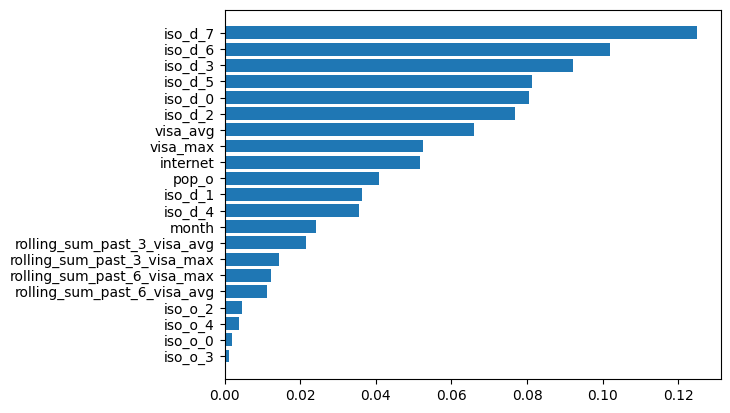

In [30]:
importances = rf_pipe.named_steps['rf'].feature_importances_

# Get column names from ColumnTransformer object
column_names = list(rf_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols


# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)

Countries fixed effects are important, also the controls internet and population, but the visa features are working :) !

With rolling windows and log transformation:

In [31]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [32]:
mse_visa_log_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    rf_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = rf_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 
    
    mse_visa_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_visa_log_dict[year] = mse_visa_log_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE using just gtrends: " + str(mse_visa_log_year))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_visa_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_visa_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE using just gtrends: 3743.1339098024723
*********
Year: 2019
X_train uses data until: 2018
RMSE using just gtrends: 1477.1095830335057
*********
Year: 2020
X_train uses data until: 2019
RMSE using just gtrends: 1971.9798436198894
*********
Year: 2021
X_train uses data until: 2020
RMSE using just gtrends: 518.045546613381


In [33]:
# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [34]:
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_visa_log.y_pred_visa_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_visa_log.y_pred_visa_log_rw, squared=False)/mse_naive)

2285.5984463718746
0.4882439288056303


Saving the visa preprocessed features:

In [35]:
# visa_to_save = trends_merged.drop(columns='target')
# visa_to_save.to_csv(path + "visa_interacted_preprocessed.csv", index=False)

## Model 2: GTrends (visa + country) + refugee outflow predictions as covariate

Adding refugee flow prediction as covariate. We train the model with the real refugee outflow data, and test it with our predicted values.

Note: we are using here Random Forest Regressor. This works better for the simpler models using mostly gtrends. When we get to the part of adding UNHCR covariates, we start using Gradient Boosting, which performs better in that case.

In [44]:
data_outflows_test = pd.read_csv("../../best predictions/outflows_best_rw (30-6).csv")
data_outflows_test = data_outflows_test[["year", "iso_o", "y_pred_gdelt_log_rw"]]
data_outflows_test = data_outflows_test.rename(columns={"y_pred_gdelt_log_rw":"ref_outflow"})

df_full = pd.read_csv(path + 'unhcr.csv', engine='pyarrow').drop_duplicates(subset=['Id','year'])[['iso_o', 'iso_d','Id','year', 'newarrival']]# 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',
        #'island_o', 'area_o', 'landlocked_o', 'PR_o', 'CL_o',
        #'typeOfViolence_o', 'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o',
        #'dead_log_o', 'Nyear_conf_o', 'dead_o', 'newarrival']]

df_full['year'] = pd.to_datetime(df_full['year'], format='%Y')
df_full["year"] = df_full["year"].dt.year
df_full = df_full.sort_values(by=['iso_o', 'iso_d','year'], ascending=[True, True, True])
df_full = df_full.reset_index(drop=True)

data_outflows = df_full.groupby(['iso_o', 'year']).newarrival.sum()
data_outflows = data_outflows.reset_index()
data_outflows = data_outflows.rename(columns={"newarrival":"ref_outflow"})

# Merge the two dataframes based on the common id variable
df_merged = df_full.merge(data_outflows, left_on=['iso_o','year'], right_on=['iso_o','year'])
df_merged = df_merged.sort_values(by=['iso_o', 'iso_d','year'], ascending=[True, True, True])
df_merged = df_merged.reset_index(drop=True)
df_merged = df_merged.rename(columns={'ref_outflow': 'ref_outflow_real'})


data_outflows = data_outflows.loc[data_outflows["year"] < 2018]
data_outflows = pd.concat([data_outflows, data_outflows_test])
data_outflows = data_outflows.sort_values(by=['iso_o', 'year'])
data_outflows = data_outflows.rename(columns={"ref_outflow":"ref_outflow_pred_test"})

df_merged = pd.merge(df_merged, data_outflows, on=["iso_o", "year"], how="left")

df_merged = df_merged.loc[df_merged["year"] <= 2021]

In [46]:
df_merged = df_merged[["iso_o", "year", "ref_outflow_pred_test"]].drop_duplicates()
df_merged.shape

(4312, 3)

In [47]:
trends_merged_out = pd.merge(trends_merged, df_merged, on=["year", "iso_o"], how="left")

In [147]:
trends_merged_out= trends_merged_out.drop(columns=["month"])

In [199]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_d']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(trends_merged_out.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', RandomForestRegressor(random_state=SEED, n_jobs=-1))])

In [200]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(trends_merged_out, 'target', test_time_start, test_time_end, 'year')

In [201]:
mse_visa_outflows_log_dict = {}
predictions_list = []
feature_importances_dict = {}
# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 

    # Get feature importances from the Random Forest model
    feature_importances = gb_pipe.named_steps['gb'].feature_importances_
    column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols
    # Store feature importances in the dictionary
    feature_importances_dict[year] = dict(zip(column_names, feature_importances))

    
    mse_visa_outflows_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_visa_outflows_log_dict[year] = mse_visa_outflows_log_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE gtrends (visa) + ref_outflows_pred: " + str(mse_visa_outflows_log_year))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_visa_outflows_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_visa_outflows_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE gtrends (visa) + ref_outflows_pred: 3746.3565298261715
*********
Year: 2019
X_train uses data until: 2018
RMSE gtrends (visa) + ref_outflows_pred: 1480.1449249625653
*********
Year: 2020
X_train uses data until: 2019
RMSE gtrends (visa) + ref_outflows_pred: 2002.4006546627618
*********
Year: 2021
X_train uses data until: 2020
RMSE gtrends (visa) + ref_outflows_pred: 120.40256259165703


In [202]:
# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged_out, 'target', test_time_start, test_time_end, 'year')

In [203]:
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_visa_outflows_log.y_pred_visa_outflows_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_visa_outflows_log.y_pred_visa_outflows_log_rw, squared=False)/mse_naive)

2261.1253347553406
0.4830160427853529


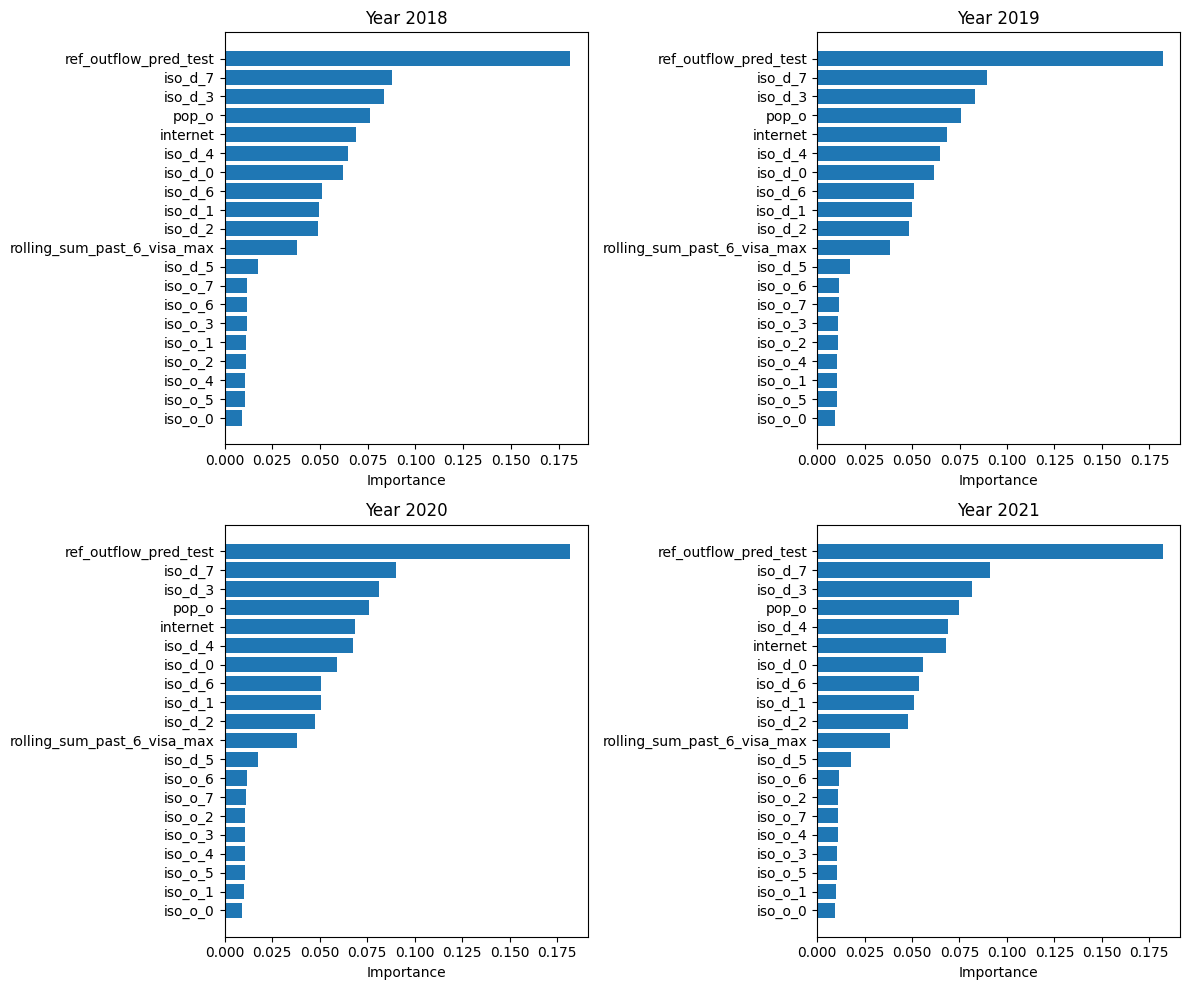

In [204]:
# List of years
years = [2018, 2019, 2020, 2021]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes to iterate over them easily
axes = axes.flatten()

# Iterate over the years and plot the bar plots in the grid
for i, year in enumerate(years):
    ax = axes[i]
    ax.set_title(f"Year {year}")  # Set title for each subplot with the corresponding year
    
    
    # Sort the feature importances in descending order and get the top 20 features
    top_features = sorted(feature_importances_dict[year].items(), key=lambda x: x[1], reverse=True)[:20]
    top_features = list(reversed(top_features))
    top_features_names, top_features_importances = zip(*top_features)
    
    # Plot the bar chart
    ax.barh(range(len(top_features_names)), top_features_importances, align='center')
    ax.set_yticks(range(len(top_features_names)))
    ax.set_yticklabels(top_features_names)
    ax.set_xlabel('Importance')

# Adjust the layout and spacing
plt.tight_layout()

# Show the plots
plt.show()




With refugee flow predictions + gtrends data, we can achieve a low RMSE (2261), that beats the naive model by more than 50%. 

That is, we can have refugee flow predictions but be unaware (or not certain, or not have data yet) of how the flows were allocated the past year. However, this strategy yields very decent results when that is the case! 

### Model 3: Gtrends (visa + country, neighboring cities and neighboring countries) + refugee outflow predictions

I am importing a dataframe that contains UNHCR covariates and Gtrends for neighboring cities and countries already preprocessed. This was generated in another notebook - because the dataset is too heavy (and has UNHCR data) is not currently on github. You can access it here: https://drive.google.com/file/d/1aEcnhXgogkk1YM1zSAciqOOATYPSIufG/view?usp=sharing 

In [154]:
dyad_covs = pd.read_csv(path + "dyad_df (partial).csv")
dyad_covs = dyad_covs.drop(columns=["Unnamed: 0"])
dyad_covs['year'] = pd.to_datetime(dyad_covs['year'], format='%Y')
dyad_covs["year"] = dyad_covs["year"].dt.year
dyad_covs = dyad_covs.loc[(dyad_covs["year"] > 2004) & (dyad_covs["year"]<= 2021)]
dyad_covs = dyad_covs.drop(columns=['Country_o', 'Country_d', 'newarrival', 'internet', 'pop_o'])

The UNHCR columns labeled `_o` have already been used in the refugee outflow predictions. Here, we are dropping them, along with other features that might not add valuable information (e.g. lags/rolling sums for conflict-related variables in the destination country - if we keep 1 lag, we'll probably be fine and we don't increase dimensionality that much).

In [158]:
dyad_covs = dyad_covs.drop(columns=['Unnamed: 22', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o', 'island_o', 'area_o',
       'landlocked_o', 'PR_o', 'CL_o', 'typeOfViolence_o', 'best_est_o',
       'Nyear_conflict_o', 'Nyear_log_o', 'dead_log_o', 'Nyear_conf_o',
       'dead_o', 'Shift_2_GDP_PP_d', 'Shift_2_GDP_PPP_d', 'Shift_2_PR_d', 'Shift_2_CL_d',
       'Shift_2_Nyear_conflict_d', 'Shift_2_Nyear_log_d',
       'Shift_2_typeOfViolence_d', 'Shift_2_Nyear_conf_d', 'Shift_1_typeOfViolence_d',
       'Shift_3_dead_d',
       'Shift_3_best_est_d', 'Shift_3_dead_log_d',
       'rolling_sum_past_3_best_est_d'])

In [159]:
dyad_covs.columns

Index(['iso_o', 'iso_d', 'year', 'Id', 'comlang_ethno', 'colony', 'comcol',
       'col45', 'smctry', 'dist', 'index0asylum', 'contig', 'comlang_off',
       'degrees_of_separation', 'Shift_1_newarrival', 'Shift_2_newarrival',
       'Shift_3_newarrival', 'rolling_sum_past_3_newarrival',
       'rolling_sum_past_5_newarrival', 'rolling_sum_past_10_newarrival',
       'pop_d', 'CPI_d', 'GDP_PP_d', 'GDP_PPP_d', 'island_d', 'area_d',
       'landlocked_d', 'PR_d', 'CL_d', 'typeOfViolence_d', 'best_est_d',
       'Nyear_conflict_d', 'Nyear_log_d', 'dead_log_d', 'Nyear_conf_d',
       'dead_d', 'Shift_1_CPI_d', 'Shift_1_GDP_PP_d', 'Shift_1_GDP_PPP_d',
       'Shift_1_PR_d', 'Shift_1_CL_d', 'Shift_1_Nyear_conflict_d',
       'Shift_1_Nyear_log_d', 'Shift_1_Nyear_conf_d', 'Shift_2_CPI_d',
       'Shift_1_dead_d', 'Shift_1_best_est_d', 'Shift_1_dead_log_d',
       'Shift_2_dead_d', 'Shift_2_best_est_d', 'Shift_2_dead_log_d',
       'rolling_sum_past_5_best_est_d', 'rolling_sum_past_10_best_est

Separating trends from UNHCR covariates.

In [160]:
trends_cols = ['city_trend_mean', 'city_trend_max',
       'country_trend_mean', 'country_trend_max', 'city_trend',
       'country_trend', 'rolling_sum_past_3_city_trend',
       'rolling_sum_past_5_city_trend', 'rolling_sum_past_10_city_trend',
       'rolling_sum_past_3_country_trend', 'rolling_sum_past_5_country_trend',
       'rolling_sum_past_10_country_trend']

In [161]:
second_trends = dyad_covs[['iso_o', 'iso_d', 'year', 'Id'] + trends_cols]
second_trends = second_trends.fillna(0)
second_trends = second_trends.drop(columns=["Id"])

In [163]:
trends_merged_t2 = pd.merge(trends_merged_out, second_trends, on=["year", "iso_o", "iso_d"], how="left")

In [205]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_d']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(trends_merged_t2.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', RandomForestRegressor(random_state=SEED, n_jobs=-1))])

In [206]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(trends_merged_t2, 'target', test_time_start, test_time_end, 'year')

In [207]:
mse_moretrends_log_dict = {}
predictions_list = []
feature_importances_dict = {}
# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 

    # Get feature importances from the Random Forest model
    feature_importances = gb_pipe.named_steps['gb'].feature_importances_
    column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols
    # Store feature importances in the dictionary
    feature_importances_dict[year] = dict(zip(column_names, feature_importances))

    
    mse_moretrends_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_moretrends_log_dict[year] = mse_moretrends_log_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE gtrends (visa) + ref_outflows_pred: " + str(mse_moretrends_log_year))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_moretrends_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_moretrends_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE gtrends (visa) + ref_outflows_pred: 3628.2709237771737
*********
Year: 2019
X_train uses data until: 2018
RMSE gtrends (visa) + ref_outflows_pred: 1390.0506816779668
*********
Year: 2020
X_train uses data until: 2019
RMSE gtrends (visa) + ref_outflows_pred: 1879.5253317526913
*********
Year: 2021
X_train uses data until: 2020
RMSE gtrends (visa) + ref_outflows_pred: 222.40204470532848


In [208]:
# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged_t2, 'target', test_time_start, test_time_end, 'year')

print(mean_squared_error(y_true=y_test, y_pred=predictions_df_moretrends_log.y_pred_moretrends_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_moretrends_log.y_pred_moretrends_log_rw, squared=False)/mse_naive)

2200.9710035238445
0.47016602223088394


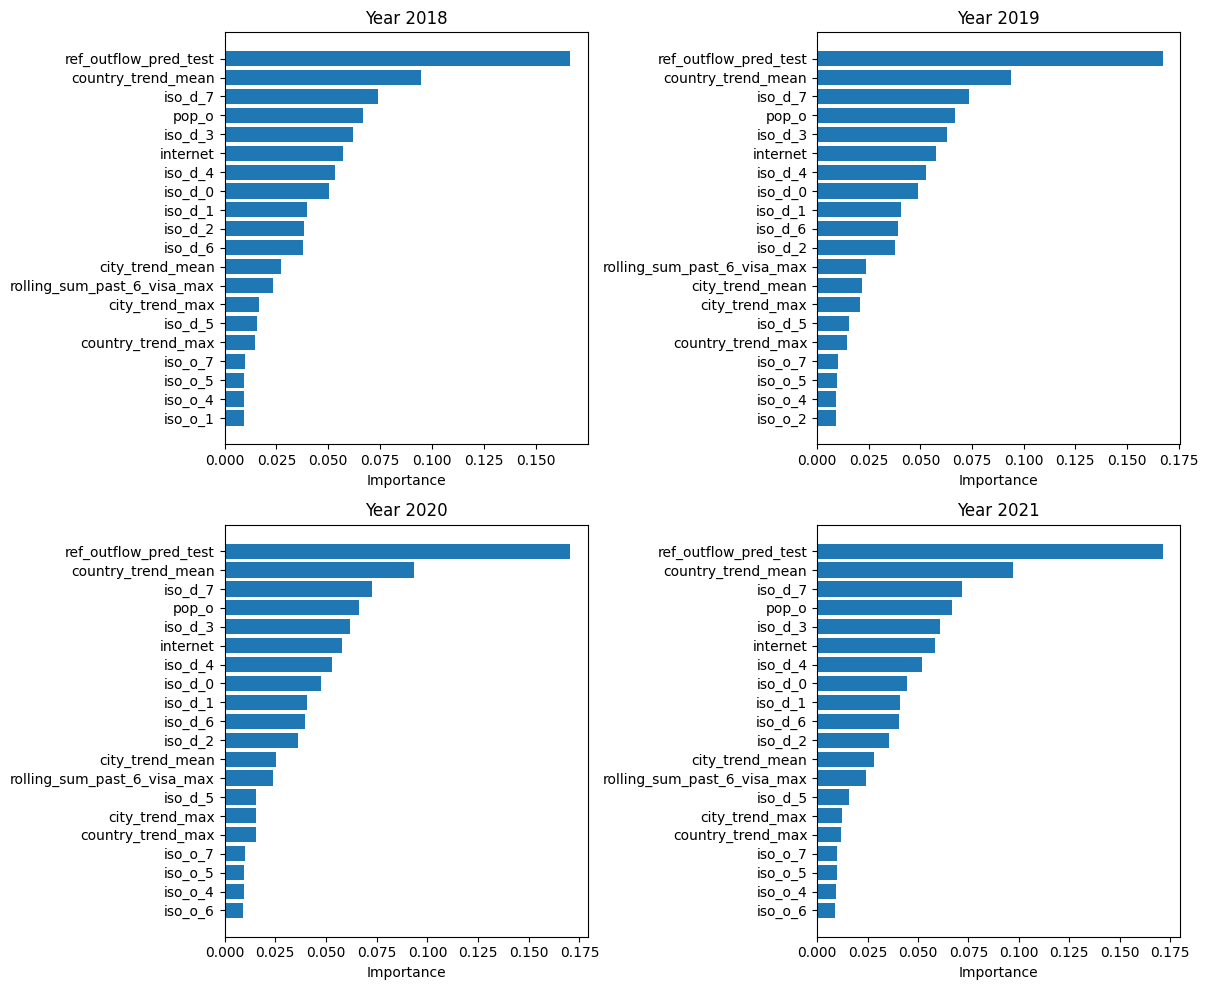

In [209]:
# List of years
years = [2018, 2019, 2020, 2021]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes to iterate over them easily
axes = axes.flatten()

# Iterate over the years and plot the bar plots in the grid
for i, year in enumerate(years):
    ax = axes[i]
    ax.set_title(f"Year {year}")  # Set title for each subplot with the corresponding year
    
    # Get the feature importances for the current year
    feature_importances = feature_importances_dict[year]
    
    # Sort the feature importances in descending order and get the top 20 features
    top_features = sorted(feature_importances_dict[year].items(), key=lambda x: x[1], reverse=True)[:20]
    top_features = list(reversed(top_features))
    top_features_names, top_features_importances = zip(*top_features)
    
    # Plot the bar chart
    ax.barh(range(len(top_features_names)), top_features_importances, align='center')
    ax.set_yticks(range(len(top_features_names)))
    ax.set_yticklabels(top_features_names)
    ax.set_xlabel('Importance')

# Adjust the layout and spacing
plt.tight_layout()

# Show the plots
plt.show()

Trends of neighboring cities and countries prove to be useful and improve predictions! 

## Model 4: full model (including UNHCR covs and historical features)

Finally, adding historical data + dyad data from UNHCR

In [234]:
unhcr_covs = dyad_covs.drop(columns=trends_cols)

In [235]:
df_merged_unhcr = pd.merge(trends_merged_t2, unhcr_covs, on=["year", "iso_o", "iso_d"], how="left")


In [236]:
df_merged_unhcr.columns

Index(['iso_o', 'iso_d', 'year', 'pop_o', 'visa_avg', 'visa_max',
       'rolling_sum_past_3_visa_avg', 'rolling_sum_past_6_visa_avg',
       'rolling_sum_past_3_visa_max', 'rolling_sum_past_6_visa_max',
       'internet', 'target', 'ref_outflow_pred_test', 'city_trend_mean',
       'city_trend_max', 'country_trend_mean', 'country_trend_max',
       'city_trend', 'country_trend', 'rolling_sum_past_3_city_trend',
       'rolling_sum_past_5_city_trend', 'rolling_sum_past_10_city_trend',
       'rolling_sum_past_3_country_trend', 'rolling_sum_past_5_country_trend',
       'rolling_sum_past_10_country_trend', 'Id', 'comlang_ethno', 'colony',
       'comcol', 'col45', 'smctry', 'dist', 'index0asylum', 'contig',
       'comlang_off', 'degrees_of_separation', 'Shift_1_newarrival',
       'Shift_2_newarrival', 'Shift_3_newarrival',
       'rolling_sum_past_3_newarrival', 'rolling_sum_past_5_newarrival',
       'rolling_sum_past_10_newarrival', 'pop_d', 'CPI_d', 'GDP_PP_d',
       'GDP_PPP_d', 

Let's first try Random Forest:

In [237]:
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_d',  'Id', 'iso_d_continent', 'typeOfViolence_d']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(df_merged_unhcr.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', RandomForestRegressor(random_state=SEED, n_jobs=-1))])

In [238]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(df_merged_unhcr, 'target', test_time_start, test_time_end, 'year')

In [227]:
mse_fullcovs_log_dict = {}
predictions_list = []
feature_importances_dict = {}
# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 

    # Get feature importances from the Random Forest model
    feature_importances = gb_pipe.named_steps['gb'].feature_importances_
    column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols
    # Store feature importances in the dictionary
    feature_importances_dict[year] = dict(zip(column_names, feature_importances))

    
    mse_fullcovs_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_fullcovs_log_dict[year] = mse_fullcovs_log_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE gtrends (visa) + ref_outflows_pred: " + str(mse_fullcovs_log_year))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_fullcovs_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_fullcovs_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE gtrends (visa) + ref_outflows_pred: 2805.7016972584224
*********
Year: 2019
X_train uses data until: 2018
RMSE gtrends (visa) + ref_outflows_pred: 978.4372237709616
*********
Year: 2020
X_train uses data until: 2019
RMSE gtrends (visa) + ref_outflows_pred: 1473.3463042963272
*********
Year: 2021
X_train uses data until: 2020
RMSE gtrends (visa) + ref_outflows_pred: 292.57724928681347


In [228]:
# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(df_merged_unhcr, 'target', test_time_start, test_time_end, 'year')

print(mean_squared_error(y_true=y_test, y_pred=predictions_df_fullcovs_log.y_pred_fullcovs_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_fullcovs_log.y_pred_fullcovs_log_rw, squared=False)/mse_naive)

2081.279238116787
0.4445977611565082


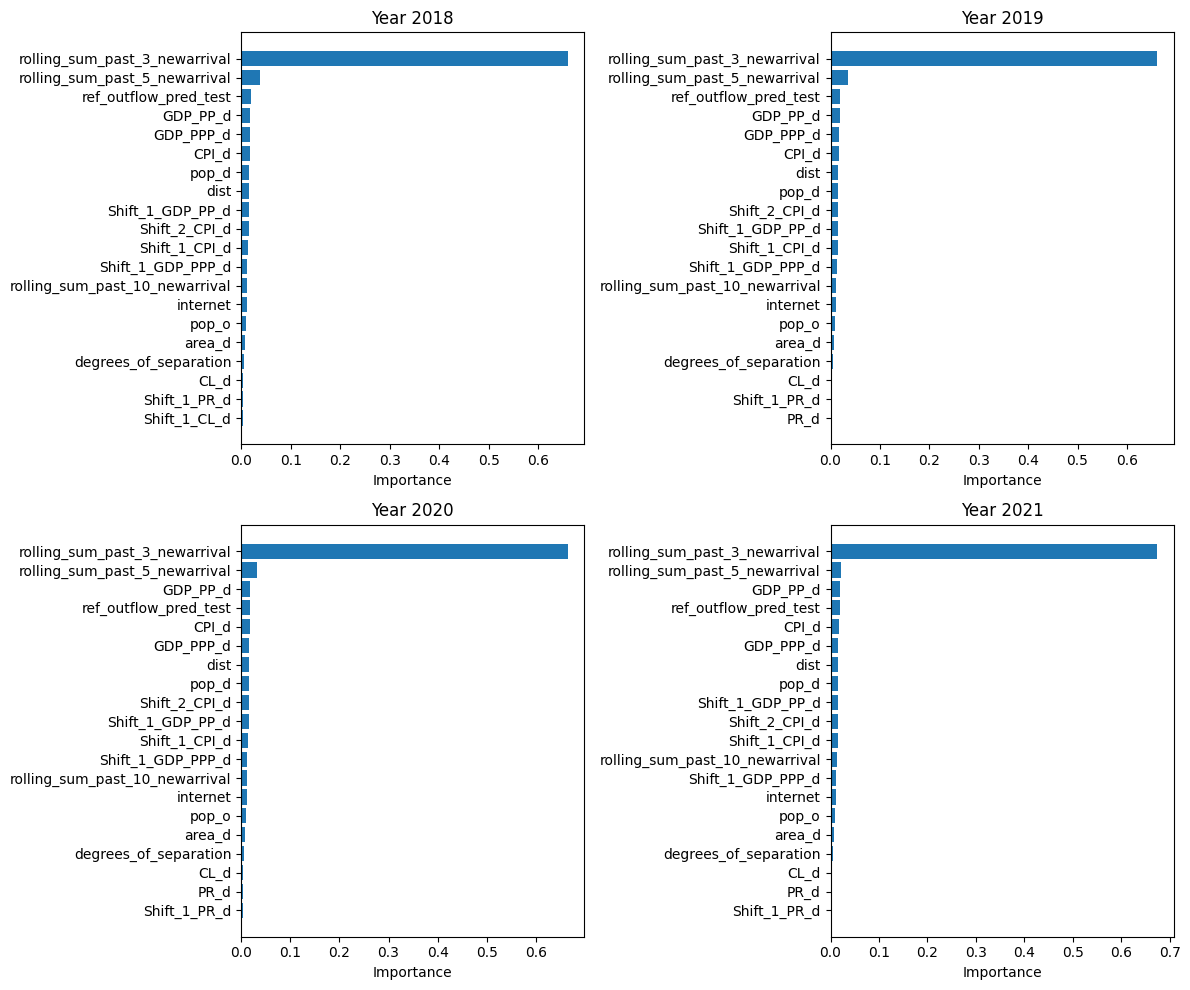

In [229]:
# List of years
years = [2018, 2019, 2020, 2021]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes to iterate over them easily
axes = axes.flatten()

# Iterate over the years and plot the bar plots in the grid
for i, year in enumerate(years):
    ax = axes[i]
    ax.set_title(f"Year {year}")  # Set title for each subplot with the corresponding year
    
    # Get the feature importances for the current year
    feature_importances = feature_importances_dict[year]
    
    # Sort the feature importances in descending order and get the top 20 features
    top_features = sorted(feature_importances_dict[year].items(), key=lambda x: x[1], reverse=True)[:20]
    top_features = list(reversed(top_features))
    top_features_names, top_features_importances = zip(*top_features)
    
    # Plot the bar chart
    ax.barh(range(len(top_features_names)), top_features_importances, align='center')
    ax.set_yticks(range(len(top_features_names)))
    ax.set_yticklabels(top_features_names)
    ax.set_xlabel('Importance')

# Adjust the layout and spacing
plt.tight_layout()

# Show the plots
plt.show()

Now **Gradient Boosting**:

In [244]:
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_d',  'Id', 'iso_d_continent', 'typeOfViolence_d']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(df_merged_unhcr.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])

In [245]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(df_merged_unhcr, 'target', test_time_start, test_time_end, 'year')

In [241]:
mse_fullcovs_gb_log_dict = {}
predictions_list = []
feature_importances_dict = {}
# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 

    # Get feature importances from the Random Forest model
    feature_importances = gb_pipe.named_steps['gb'].feature_importances_
    column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols
    # Store feature importances in the dictionary
    feature_importances_dict[year] = dict(zip(column_names, feature_importances))

    
    mse_fullcovs_gb_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_fullcovs_gb_log_dict[year] = mse_fullcovs_gb_log_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE gtrends (visa) + ref_outflows_pred: " + str(mse_fullcovs_gb_log_year))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_fullcovs_gb_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_fullcovs_gb_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE gtrends (visa) + ref_outflows_pred: 3117.0584019266935
*********
Year: 2019
X_train uses data until: 2018
RMSE gtrends (visa) + ref_outflows_pred: 1201.3714933805488
*********
Year: 2020
X_train uses data until: 2019
RMSE gtrends (visa) + ref_outflows_pred: 1733.4760287975835
*********
Year: 2021
X_train uses data until: 2020
RMSE gtrends (visa) + ref_outflows_pred: 88.42477097827322


In [242]:
# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(df_merged_unhcr, 'target', test_time_start, test_time_end, 'year')

print(mean_squared_error(y_true=y_test, y_pred=predictions_df_fullcovs_gb_log.y_pred_fullcovs_gb_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_fullcovs_gb_log.y_pred_fullcovs_gb_log_rw, squared=False)/mse_naive)

1993.9991467317293
0.4259532023137247


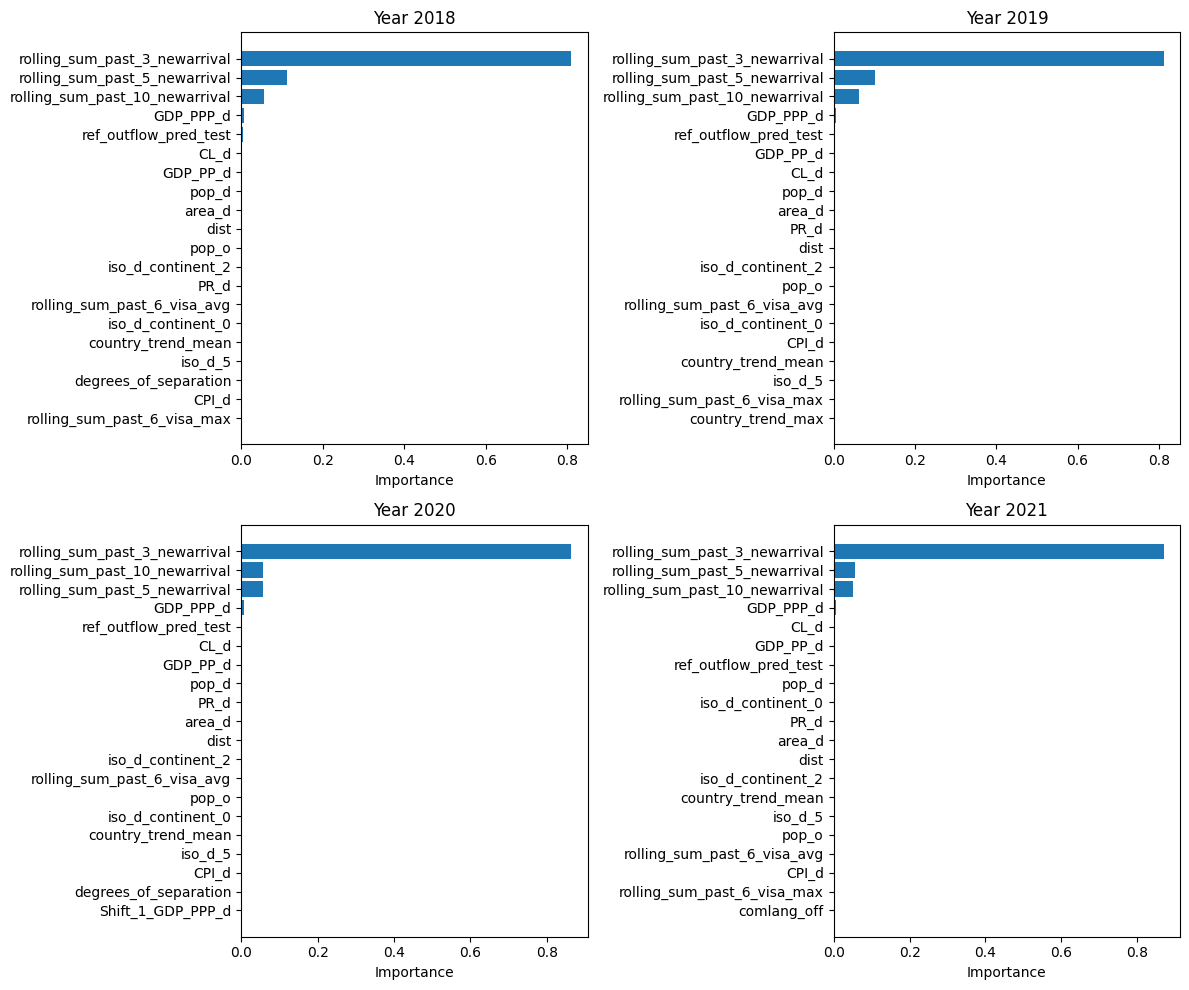

In [243]:
# List of years
years = [2018, 2019, 2020, 2021]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes to iterate over them easily
axes = axes.flatten()

# Iterate over the years and plot the bar plots in the grid
for i, year in enumerate(years):
    ax = axes[i]
    ax.set_title(f"Year {year}")  # Set title for each subplot with the corresponding year
    
    
    # Sort the feature importances in descending order and get the top 20 features
    top_features = sorted(feature_importances_dict[year].items(), key=lambda x: x[1], reverse=True)[:20]
    top_features = list(reversed(top_features))
    top_features_names, top_features_importances = zip(*top_features)
    
    # Plot the bar chart
    ax.barh(range(len(top_features_names)), top_features_importances, align='center')
    ax.set_yticks(range(len(top_features_names)))
    ax.set_yticklabels(top_features_names)
    ax.set_xlabel('Importance')

# Adjust the layout and spacing
plt.tight_layout()

# Show the plots
plt.show()

## Model 5: full model + undersampling 0s

GB full - undersampling 0s

In [246]:
mse_fullcovs_unders_log_dict = {}
predictions_list = []
feature_importances_dict = {}

# Iterate over the test sets for each year

for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):

    zeros_sample_index = y_train[y_train == 0].sample(frac=.20, random_state=42).index
    X_train_undersampled = X_train[(y_train != 0) | (y_train.index.isin(zeros_sample_index))]
    y_train_undersampled = y_train[(y_train != 0) | (y_train.index.isin(zeros_sample_index))]

    epsilon = 1e-8
    y_train_log = np.log(y_train_undersampled + epsilon)

    gb_pipe.fit(X_train_undersampled, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 

    # Get feature importances from the Random Forest model
    feature_importances = gb_pipe.named_steps['gb'].feature_importances_
    column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols
    # Store feature importances in the dictionary
    feature_importances_dict[year] = dict(zip(column_names, feature_importances))

    
    mse_fullcovs_unders_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_fullcovs_unders_log_dict[year] = mse_fullcovs_unders_log_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE full model (0 undersample): " + str(mse_fullcovs_unders_log_year))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_fullcovs_unders_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_fullcovs_unders_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE full model (0 undersample): 3205.960645988453
*********
Year: 2019
X_train uses data until: 2018
RMSE full model (0 undersample): 1214.3150738655697
*********
Year: 2020
X_train uses data until: 2019
RMSE full model (0 undersample): 1720.3899047174014
*********
Year: 2021
X_train uses data until: 2020
RMSE full model (0 undersample): 99.37330554447578


In [247]:
# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(df_merged_unhcr, 'target', test_time_start, test_time_end, 'year')

print(mean_squared_error(y_true=y_test, y_pred=predictions_df_fullcovs_unders_log.y_pred_fullcovs_unders_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_fullcovs_unders_log.y_pred_fullcovs_unders_log_rw, squared=False)/mse_naive)

1985.6271204398556
0.42416479061118045


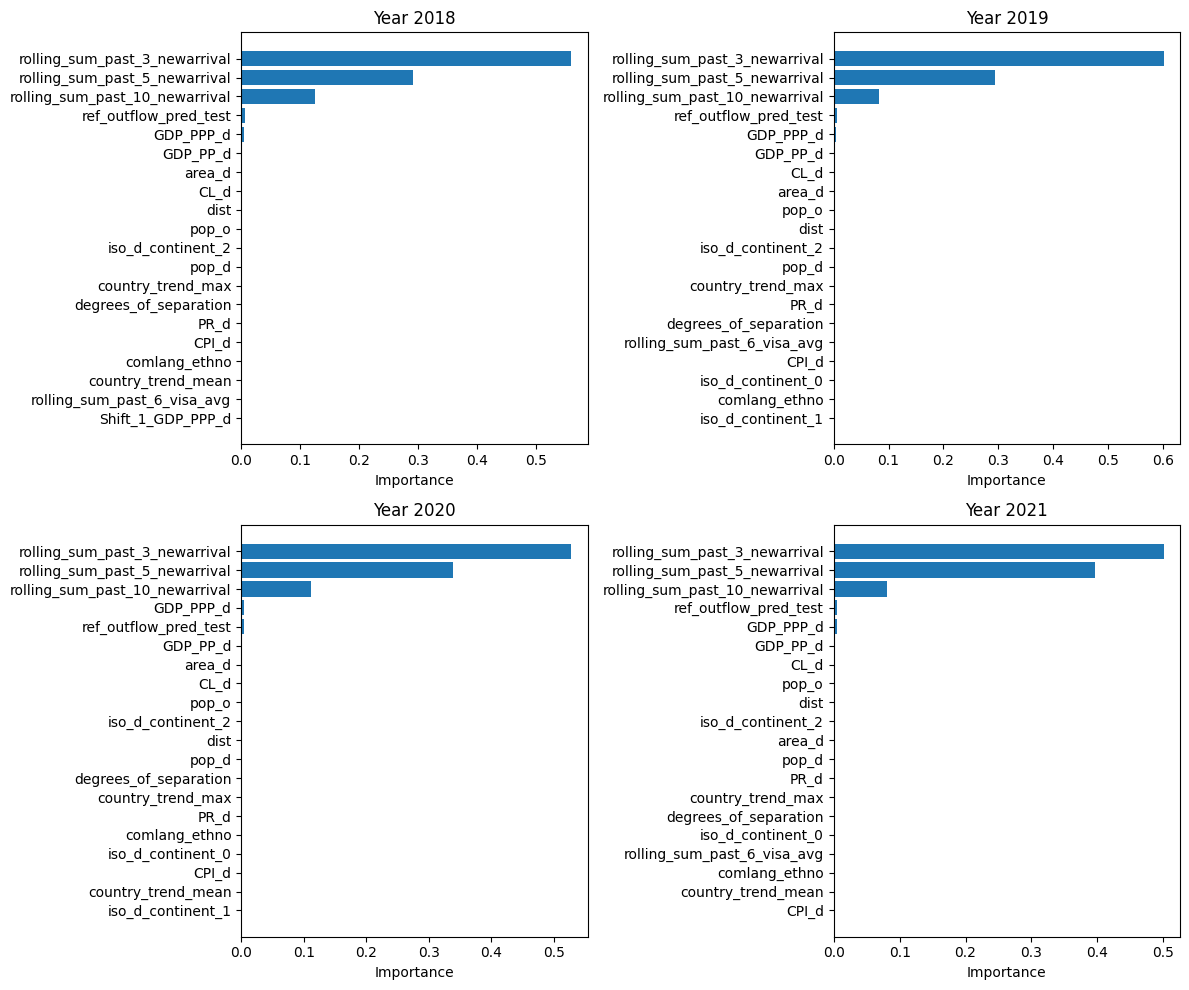

In [248]:
# List of years
years = [2018, 2019, 2020, 2021]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes to iterate over them easily
axes = axes.flatten()

# Iterate over the years and plot the bar plots in the grid
for i, year in enumerate(years):
    ax = axes[i]
    ax.set_title(f"Year {year}")  # Set title for each subplot with the corresponding year
    
    
    # Sort the feature importances in descending order and get the top 20 features
    top_features = sorted(feature_importances_dict[year].items(), key=lambda x: x[1], reverse=True)[:20]
    top_features = list(reversed(top_features))
    top_features_names, top_features_importances = zip(*top_features)
    
    # Plot the bar chart
    ax.barh(range(len(top_features_names)), top_features_importances, align='center')
    ax.set_yticks(range(len(top_features_names)))
    ax.set_yticklabels(top_features_names)
    ax.set_xlabel('Importance')

# Adjust the layout and spacing
plt.tight_layout()

# Show the plots
plt.show()

## Model 6: how does the model looks without GTrends?

This implementation takes exclusively UNHCR covariates and historical features. But it does use our refugee outflow predictions.

In [218]:
unhcr_covs_2 = pd.merge(trends_merged_t2[["year", "iso_o", "iso_d", "target", "ref_outflow_pred_test"]], unhcr_covs, on=["year", "iso_o", "iso_d"], how="left")

In [219]:
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_d',  'Id', 'iso_d_continent', 'typeOfViolence_d']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(unhcr_covs_2.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])

In [220]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(unhcr_covs_2, 'target', test_time_start, test_time_end, 'year')

In [221]:

mse_onlyunhcr_gb_log_dict = {}
predictions_list = []
feature_importances_dict = {}
# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 

    # Get feature importances from the Random Forest model
    feature_importances = gb_pipe.named_steps['gb'].feature_importances_
    column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols
    # Store feature importances in the dictionary
    feature_importances_dict[year] = dict(zip(column_names, feature_importances))

    
    mse_onlyunhcr_gb_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_onlyunhcr_gb_log_dict[year] = mse_onlyunhcr_gb_log_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE gtrends - only UNHCR + ref_outflows pred: " + str(mse_onlyunhcr_gb_log_year))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_onlyunhcr_gb_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_onlyunhcr_gb_log = pd.concat(predictions_list, ignore_index=True)


*********
Year: 2018
X_train uses data until: 2017
RMSE gtrends - only UNHCR + ref_outflows pred: 3072.4177621483936
*********
Year: 2019
X_train uses data until: 2018
RMSE gtrends - only UNHCR + ref_outflows pred: 1199.757749494656
*********
Year: 2020
X_train uses data until: 2019
RMSE gtrends - only UNHCR + ref_outflows pred: 1736.60013818161
*********
Year: 2021
X_train uses data until: 2020
RMSE gtrends - only UNHCR + ref_outflows pred: 84.84458273686074


In [222]:

# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(unhcr_covs_2, 'target', test_time_start, test_time_end, 'year')

print(mean_squared_error(y_true=y_test, y_pred=predictions_df_onlyunhcr_gb_log.y_pred_onlyunhcr_gb_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_onlyunhcr_gb_log.y_pred_onlyunhcr_gb_log_rw, squared=False)/mse_naive)


1995.3749336827025
0.4262470945445358


The results by themselves are pretty good. With gtrends + undersampling they improve, but ever so slightly. 

However, a main takeaway is what we can do without certainty of historical features at the dyad level.

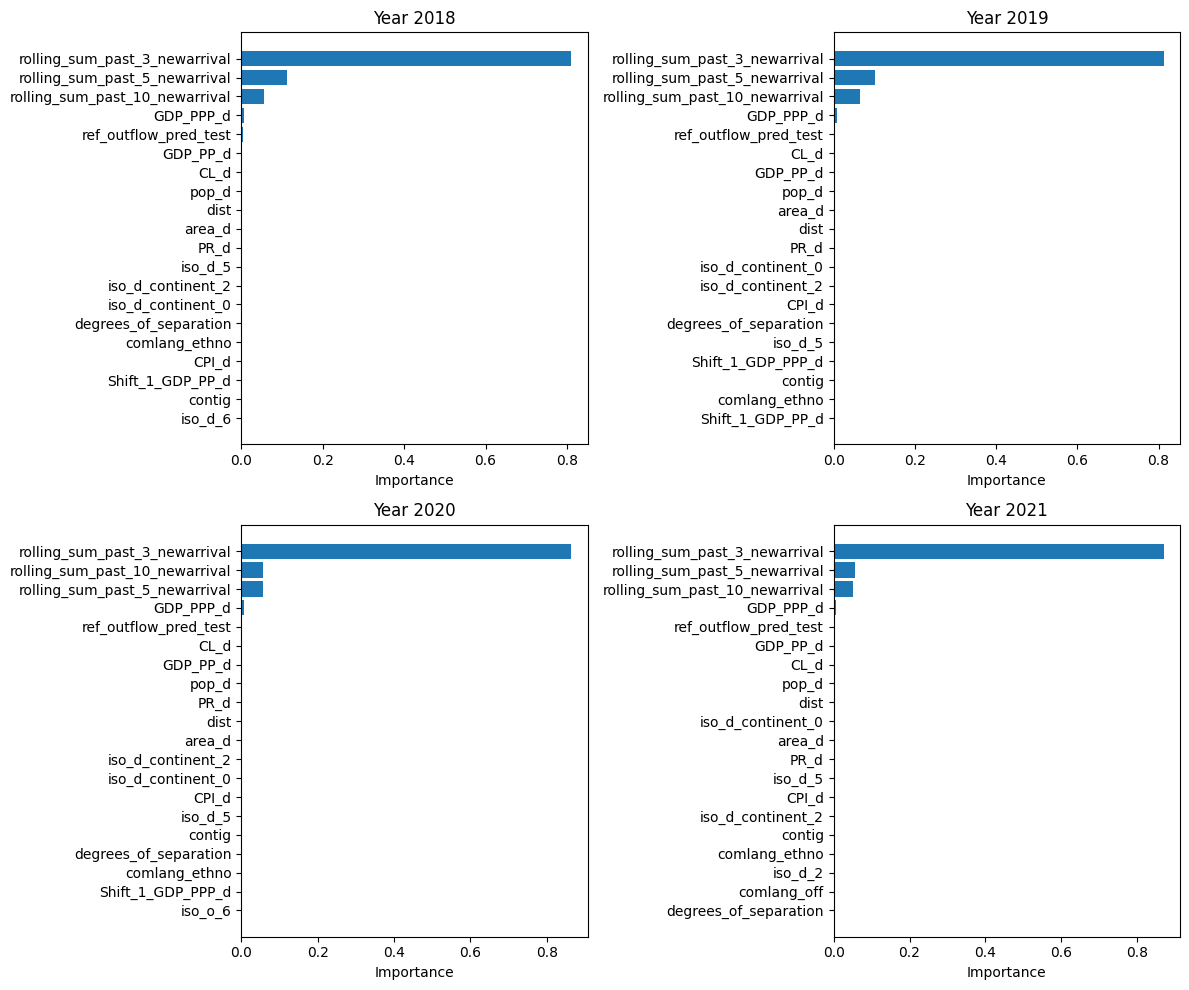

In [224]:

# List of years
years = [2018, 2019, 2020, 2021]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes to iterate over them easily
axes = axes.flatten()

# Iterate over the years and plot the bar plots in the grid
for i, year in enumerate(years):
    ax = axes[i]
    ax.set_title(f"Year {year}")  # Set title for each subplot with the corresponding year
    
    
    # Sort the feature importances in descending order and get the top 20 features
    top_features = sorted(feature_importances_dict[year].items(), key=lambda x: x[1], reverse=True)[:20]
    top_features = list(reversed(top_features))
    top_features_names, top_features_importances = zip(*top_features)
    
    # Plot the bar chart
    ax.barh(range(len(top_features_names)), top_features_importances, align='center')
    ax.set_yticks(range(len(top_features_names)))
    ax.set_yticklabels(top_features_names)
    ax.set_xlabel('Importance')

# Adjust the layout and spacing
plt.tight_layout()

# Show the plots
plt.show()